<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_native_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
#%pip install jiwer transformers evaluate 

## Fine-tune TrOCR on the IAM Handwriting Database

In this notebook, we are going to fine-tune a pre-trained TrOCR model on the [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database), a collection of annotated images of handwritten text.

We will do this using the new `VisionEncoderDecoderModel` class, which can be used to combine any image Transformer encoder (such as ViT, BEiT) with any text Transformer as decoder (such as BERT, RoBERTa, GPT-2). TrOCR is an instance of this, as it has an encoder-decoder architecture, with the weights of the encoder initialized from a pre-trained BEiT, and the weights of the decoder initialized from a pre-trained RoBERTa. The weights of the cross-attention layer were randomly initialized, before the authors pre-trained the model further on millions of (partially synthetic) annotated images of handwritten text. 

This figure gives a good overview of the model (from the original paper):

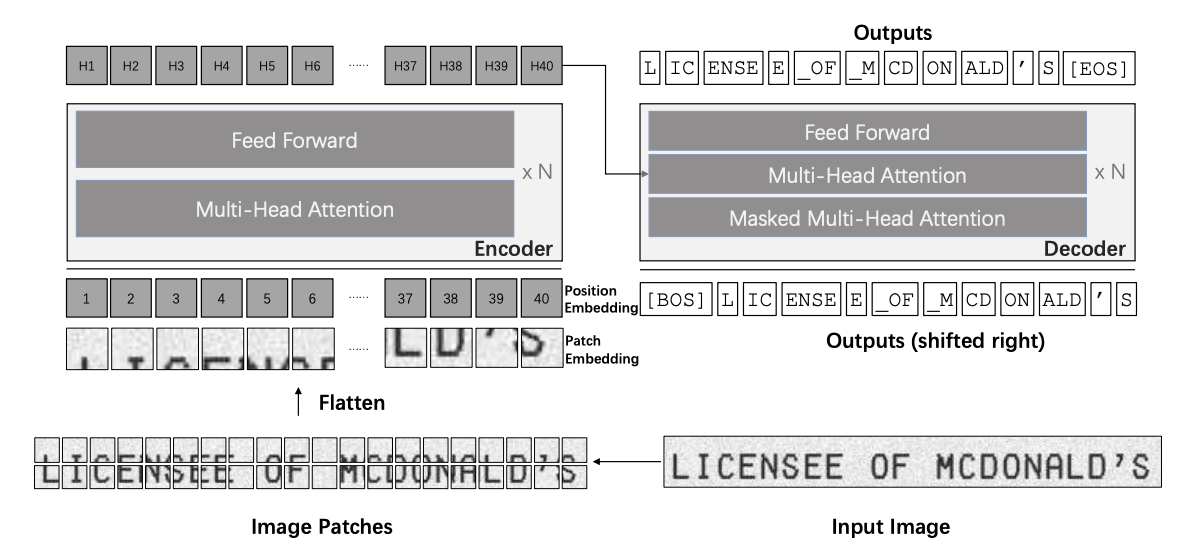

* TrOCR paper: https://arxiv.org/abs/2109.10282
* TrOCR documentation: https://huggingface.co/transformers/master/model_doc/trocr.html


Note that Patrick also wrote a very good [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder) on warm-starting encoder-decoder models (which is what the TrOCR authors did). This blog post was very helpful for me to create this notebook. 

We will fine-tune the model using native PyTorch.



## Set-up environment

First, let's install the required libraries:
* Transformers (for the TrOCR model)
* Datasets & Jiwer (for the evaluation metric)

We will not be using HuggingFace Datasets in this notebook for data preprocessing, we will just create a good old basic PyTorch Dataset.

In [174]:
#%pip install -q transformers

In [175]:
#%pip install -q datasets jiwer

# Global Imports 

In [176]:
import os
import numpy as np
import pandas as pd
import torch 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import TrOCRProcessor
from transformers import VisionEncoderDecoderModel
from torch.utils.data import DataLoader
from evaluate import load
from transformers import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.functional import F
from transformers import AutoTokenizer

# Local Imports

# Globals

In [177]:
MODEL_NAME: str = "microsoft/trocr-base-handwritten"
BATCH_SIZE: int = 4
MAX_TARGET_LENGTH: int = 128 # token vector size

# Paths

In [178]:
__filedir__: str = os.path.abspath(".")
dataset_dirpath: str = os.path.join(
    __filedir__,
    "dataset"
)
gt_test_filepath: str = os.path.join(
    __filedir__,
    "dataset.csv"
)

## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr). 

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [179]:
dataset_df: pd.DataFrame = pd.read_csv(gt_test_filepath)
dataset_df.head()

,FileName,Label
0,01.jpg,Hello World!
1,02.jpg,Hi there!
2,03.jpg,What is the time?
3,04.jpg,Where am I?


We split up the data into training + testing, using sklearn's `train_test_split` function.

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`). 

In [180]:

class HandwrittenTextDataset(Dataset):
    def __init__(
        self, 
        dataset_dirpath: str, 
        filenames: list[str], 
        label_strings: list[str],
        processor: TrOCRProcessor, 
        max_target_length: int = 128,
        pad_token_overwrite: int = -100
    ):
        assert len(label_strings) == len(filenames)
        
        self.dataset_dirpath: str = dataset_dirpath
        self.filenames: list[str] = filenames
        self.filepaths: list[str] = [
            os.path.join(
                dataset_dirpath,
                filename
            ) for filename in filenames
        ]  
        self.label_strings: list[str] = label_strings
        self.processor: TrOCRProcessor = processor
        self.max_target_length: int = max_target_length
        self.pad_token_overwrite: int = pad_token_overwrite
        self.pad_token_id: int = self.processor.tokenizer.pad_token_id
    
    
    def restore_label_padding(
        self,
        label: torch.Tensor,
        inplace=True    
    ) -> torch.Tensor:
        
        if label.shape[-1] < self.max_target_length:
            pad_amount = self.max_target_length - label.shape[-1]
            # Pad on the right along the last dimension
            label = F.pad(label, (0, pad_amount), value=self.pad_token_overwrite)
        
        out_label_tensor: torch.Tensor = label
        
        if not inplace:
            out_label_tensor: torch.Tensor 
            out_label_tensor = label.detach().clone()
            
        mask: torch.Tensor = out_label_tensor == self.pad_token_overwrite  
        out_label_tensor[mask] = self.pad_token_id
        
        return out_label_tensor
        
    def overwrite_label_padding(
        self,
        label: torch.Tensor,
        inplace=True    
    ) -> torch.Tensor:
        
        out_label_tensor: torch.Tensor = label
        
        if not inplace:
            out_label_tensor: torch.Tensor 
            out_label_tensor = label.detach().clone()
            
        mask: torch.Tensor = out_label_tensor == self.pad_token_id
        out_label_tensor[mask] = self.pad_token_overwrite
        
        return out_label_tensor
    
    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(
        self,
        index: int
    ) -> tuple[torch.Tensor, torch.Tensor]:
        # get file name + text 
        filepath: str = self.filepaths[index]
        text_label: str = self.label_strings[index]
        
        text_image: Image.Image = Image.open(filepath).convert("RGB")
        text_image_tensor: torch.Tensor = self.processor(
            text_image, 
            return_tensors="pt"
        ).pixel_values
        
        labels_tensor: torch.Tensor = torch.tensor(
            self.processor.tokenizer(
                text_label, 
                padding="max_length", 
                max_length=self.max_target_length
            ).input_ids
        )
        
        self.overwrite_label_padding(
            label=labels_tensor,
            inplace=True
        )

        return text_image_tensor.squeeze(), labels_tensor
        

Let's initialize the training and evaluation datasets:

In [181]:
filenames: list[str] = dataset_df["FileName"].to_list()
label_strings: list[str] = dataset_df["Label"].to_list()

In [182]:
train_file_label_pairs: list[tuple[str, str]]
test_file_label_pairs: list[tuple[str, str]]

train_file_label_pairs, test_file_label_pairs = train_test_split(
    list(
        zip(
            filenames, 
            label_strings
        )
    ),
    test_size=0.2
)

In [183]:

train_filenames, train_label_strings = list(zip(*train_file_label_pairs))
test_filenames, test_label_strings = list(zip(*test_file_label_pairs))

In [184]:
print(train_filenames, train_label_strings)
print(test_filenames, test_label_strings)

('01.jpg', '02.jpg', '03.jpg') ('Hello World!', 'Hi there!', 'What is the time?')
('04.jpg',) ('Where am I?',)


In [186]:
tokeniser = AutoTokenizer.from_pretrained(
    "./apl_tokeniser"
)

processor = TrOCRProcessor.from_pretrained(
    "microsoft/trocr-base-handwritten"
)
processor.tokenizer = tokeniser

train_dataset = HandwrittenTextDataset(
    dataset_dirpath=dataset_dirpath,
    filenames=train_filenames,
    label_strings=train_label_strings,
    processor=processor
)
eval_dataset = HandwrittenTextDataset(
    dataset_dirpath=dataset_dirpath,
    filenames=test_filenames,
    label_strings=test_label_strings,
    processor=processor
)

In [187]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 3
Number of validation examples: 1


Let's verify an example from the training dataset:

In [188]:
_image: torch.Tensor
_label: torch.Tensor
_image, _label = train_dataset[0]


In [189]:
_image, _label

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor([    0, 31414,   623,   328,     2,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -

We can also check the original image and decode the labels:

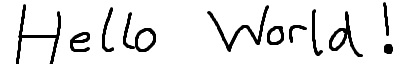

In [190]:
image = Image.open(
    train_dataset.filepaths[0]
).convert("RGB")
image

In [191]:
train_dataset.restore_label_padding(_label)

tensor([    0, 31414,   623,   328,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])

In [192]:
def decode_raw_model_output(
    label
) -> list[str]:
    
    _restored_label: torch.Tensor = train_dataset.restore_label_padding(
        label, 
        inplace=False
    )
    
    if len(_restored_label.shape) == 1:
        _restored_label = _restored_label.unsqueeze(0)
    
    strings: list[str] = []
    
    label_tensor: torch.Tensor
    for label_tensor in _restored_label:
        label_str: str = processor.decode(
            label_tensor, 
            skip_special_tokens=True
        )
        strings.append(label_str)
    
    return strings


In [193]:
decode_raw_model_output(
    torch.unsqueeze(
        _label,
        0
    )
)

['Hello World!']

In [194]:
_label

tensor([    0, 31414,   623,   328,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])

Let's create corresponding dataloaders:

In [195]:

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
eval_dataloader = DataLoader(
    eval_dataset, 
    batch_size=BATCH_SIZE
)

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [196]:
device: torch.device = torch.device(
    "cuda" 
    if torch.cuda.is_available() 
    else "cpu"
)

model: VisionEncoderDecoderModel = VisionEncoderDecoderModel.from_pretrained(
    "microsoft/trocr-base-stage1"
)
model = model.to(device)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [197]:
model.config.decoder_start_token_id = tokeniser.cls_token_id
model.config.pad_token_id = tokeniser.pad_token_id
model.config.eos_token_id = tokeniser.sep_token_id
model.config.vocab_size = len(tokeniser)
model.decoder.resize_token_embeddings(len(tokeniser))

model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 5

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [198]:

cer_metric = load("cer")

In [199]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

c:\Users\Leon\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training model...: 0it [00:00, ?it/s]

Training model...: 1it [00:06,  6.72s/it]


Loss after epoch 0: 8.558979034423828


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Leon\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\utils.py:1493: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


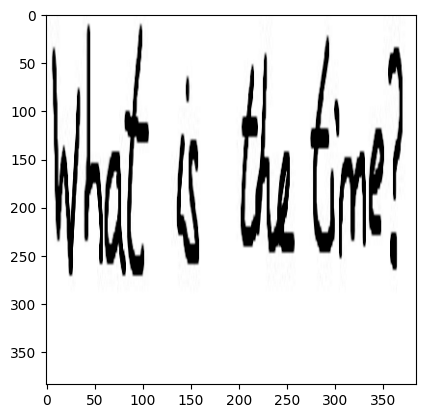

What isthatWhatthatWhatWhatWhatthatthatWhatThatWhatWhathatWhatWhatwhatWhatWhatThatThatWhatthatThatWhatThatthatWhathatthatWhatwhatthatWhatHatWhatWhatwatWhatWhat thatWhatthatwhatWhatThatwhatWhatthathatWhatthat thatWhatWhatButWhatWhatWantWhatWhatHat


100%|██████████| 1/1 [02:05<00:00, 125.57s/it]


Validation CER: 17.763157894736842


Training model...: 1it [00:07,  7.38s/it]


Loss after epoch 1: 14.329237937927246


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


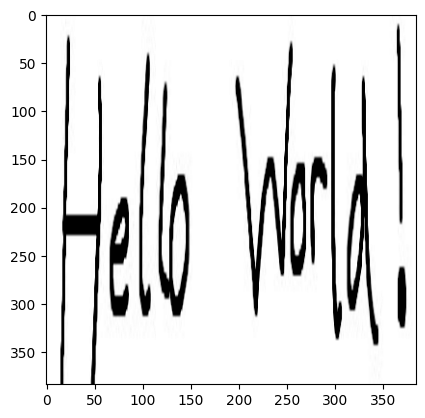

100%|██████████| 1/1 [02:00<00:00, 120.69s/it]


el World World World Work World WorldHOW World World low World WorldNOW World WorldWorld World World Vor World WorldO World WorldOV World Worldo World Worldworld World Worldboro World WorldHow World WorldOW World World War World WorldWord World Worldlor World Worldlo World Worldow World World@ World World world World
Validation CER: 22.86842105263158


Training model...: 1it [00:07,  7.67s/it]


Loss after epoch 2: 6.2226433753967285


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


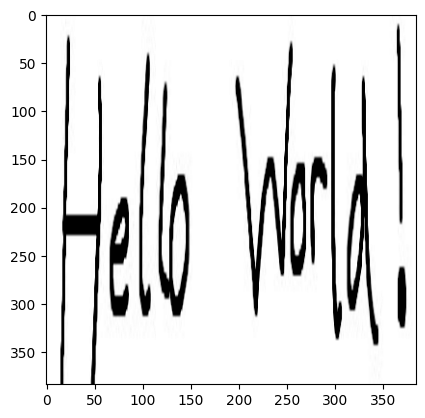

100%|██████████| 1/1 [00:16<00:00, 16.45s/it]


!!
Validation CER: 0.6052631578947368


Training model...: 1it [00:07,  7.52s/it]


Loss after epoch 3: 5.168601036071777


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


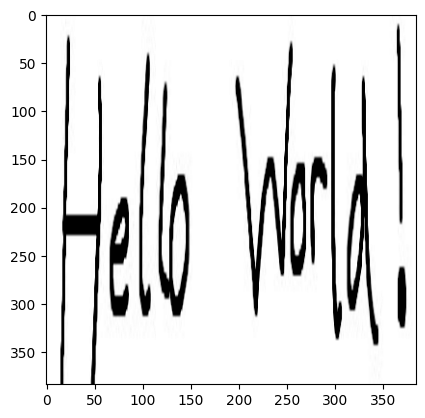

100%|██████████| 1/1 [00:10<00:00, 10.61s/it]


!!
Validation CER: 0.6052631578947368


Training model...: 1it [00:04,  4.93s/it]


Loss after epoch 4: 3.1105892658233643


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


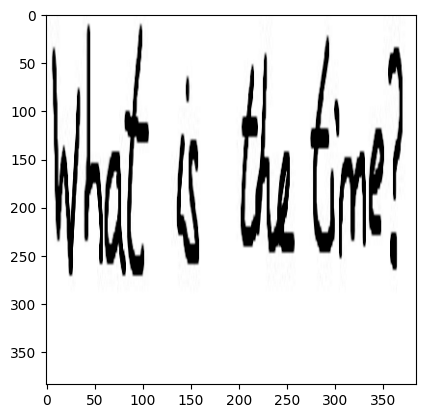

100%|██████████| 1/1 [00:12<00:00, 12.12s/it]


 there is there time time?
Validation CER: 0.6052631578947368


Training model...: 1it [00:04,  4.95s/it]


Loss after epoch 5: 1.5963646173477173


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


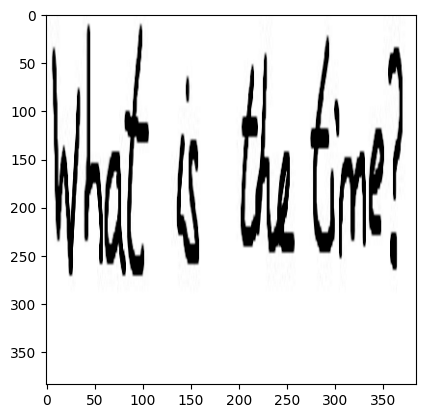

100%|██████████| 1/1 [00:23<00:00, 23.54s/it]


 there is the time time?
Validation CER: 0.4473684210526316


Training model...: 1it [00:07,  7.44s/it]


Loss after epoch 6: 1.8858537673950195


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


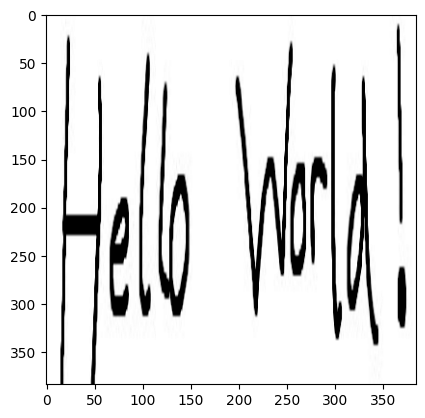

100%|██████████| 1/1 [00:17<00:00, 17.50s/it]


 World!
Validation CER: 0.23684210526315788


Training model...: 1it [00:06,  6.42s/it]


Loss after epoch 7: 1.055495262145996


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


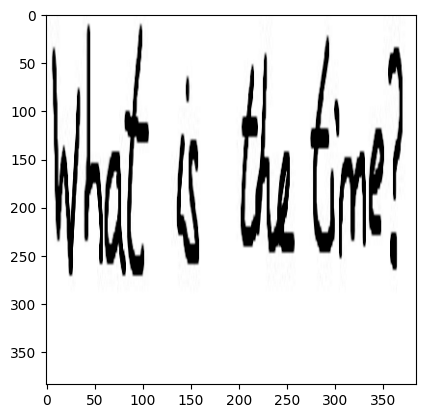

100%|██████████| 1/1 [00:18<00:00, 18.75s/it]


What is the time?
Validation CER: 0.23684210526315788


Training model...: 1it [00:04,  4.81s/it]


Loss after epoch 8: 0.6637738943099976


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


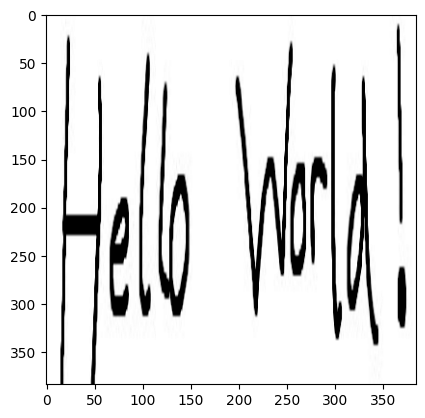

100%|██████████| 1/1 [00:10<00:00, 10.29s/it]


Hello World!
Validation CER: 0.0


Training model...: 1it [00:04,  4.87s/it]


Loss after epoch 9: 0.5234070420265198


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


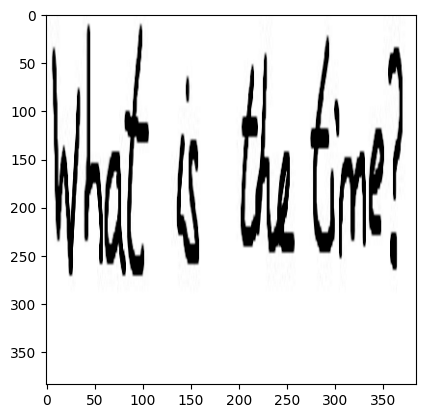

100%|██████████| 1/1 [00:09<00:00,  9.60s/it]


What is time?
Validation CER: 0.2631578947368421


Training model...: 1it [00:04,  4.87s/it]


Loss after epoch 10: 1.1250765323638916


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


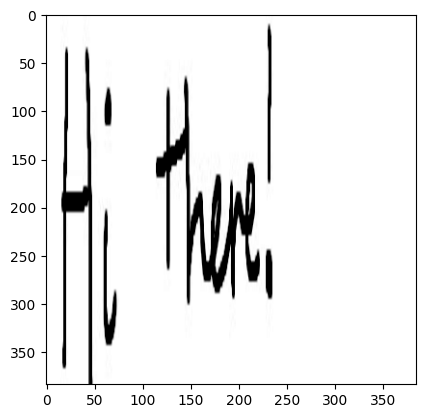

100%|██████████| 1/1 [00:11<00:00, 11.44s/it]


Hi there!
Validation CER: 0.0


Training model...: 1it [00:04,  4.83s/it]


Loss after epoch 11: 0.5263739824295044


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


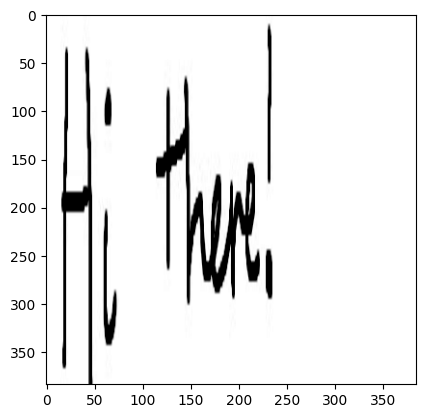

100%|██████████| 1/1 [00:14<00:00, 14.16s/it]


Hi there!
Validation CER: 0.47368421052631576


Training model...: 1it [00:04,  4.80s/it]


Loss after epoch 12: 1.250098466873169


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


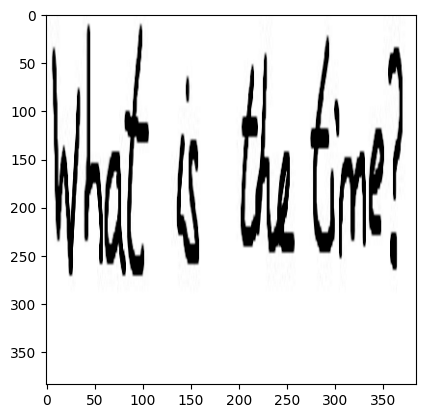

100%|██████████| 1/1 [00:23<00:00, 23.97s/it]


What is the the the time the time time time?
Validation CER: 0.7105263157894737


Training model...: 1it [00:04,  4.86s/it]


Loss after epoch 13: 0.9666119813919067


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


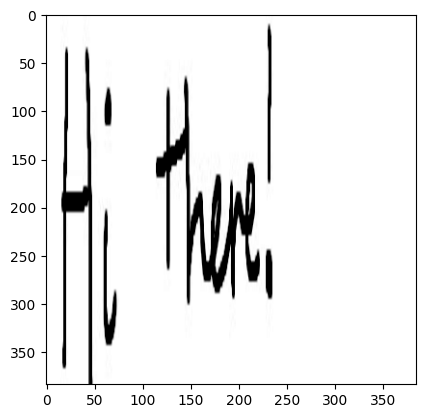

100%|██████████| 1/1 [00:12<00:00, 12.86s/it]


Hi there!
Validation CER: 0.13157894736842105


Training model...: 1it [00:04,  4.78s/it]


Loss after epoch 14: 0.8099473714828491


  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


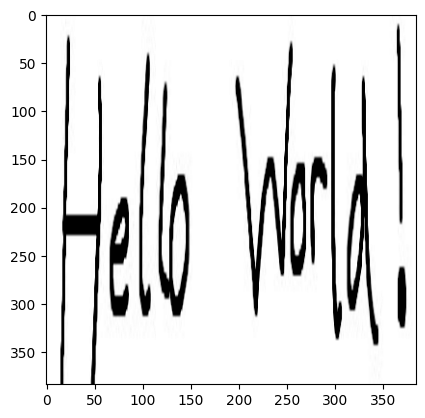

100%|██████████| 1/1 [00:07<00:00,  7.78s/it]


Hello World!
Validation CER: 0.3157894736842105


Training model...: 1it [00:04,  4.89s/it]


Loss after epoch 15: 0.6828489899635315


  0%|          | 0/1 [00:26<?, ?it/s]


KeyboardInterrupt: 

In [200]:

optimizer: AdamW = AdamW(
  model.parameters(), 
  lr=5e-5
)

epoch: int
for epoch in range(100):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss: float = 0.0
   
   X: torch.Tensor
   y: torch.Tensor
   for X, y in tqdm(
    iterable=train_dataloader,
    desc="Training model...",
    total=len(train_dataset)//BATCH_SIZE
    ):
      X = X.to(device)
      y = y.to(device)
      
      # forward + backward + optimize
      outputs = model(
        pixel_values=X,
        labels=y
      )
      loss: torch.Tensor = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
   # evaluate
   model.eval()
   valid_cer: float = 0.0
   with torch.no_grad():
     for batch in tqdm(
       eval_dataloader
      ):
        # run batch generation
        outputs = model.generate(X.to(device))
        # compute metrics
       
        predicted_output: str = decode_raw_model_output(
          outputs
        )
        
        plt.imshow(X.detach().cpu()[0, :, :, :].permute((1, 2, 0)))
        plt.show()
        print(predicted_output[0])
        
        cer: dict | None = compute_cer(
          pred_ids=outputs, 
          label_ids=y
          )
        valid_cer += cer 

   print("Validation CER:", valid_cer / len(eval_dataloader))

model.save_pretrained(".")

## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.